In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib as mpl
from google.colab import drive
drive.mount('/content/drive')

mpl.font_manager.fontManager.addfont('/content/drive/My Drive/K2D-Regular.ttf')
mpl.rc('font', family='K2D', size=10, weight=150)

Mounted at /content/drive


In [3]:
cbdf = pd.DataFrame()
cbdf = pd.read_excel('/content/drive/My Drive/Customer_Behaviors.xlsx', dtype={'คุณเกิดวันที่เท่าไหร่' : str})

print(cbdf.shape)
cbdf = cbdf[cbdf.columns[1:]]

(63, 64)


In [4]:
from datetime import datetime

df = cbdf.copy()

# rename columns
int_cols = [ c.replace('คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด','Interest') for c in df.columns[:30] ]
con_cols = [ c.replace('คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน','Consumption') for c in df.columns[30:60] ]
df.columns = int_cols + con_cols + ['interests', 'dob', 'gender']

# make answers categorical
intr_cattype = pd.CategoricalDtype(categories=['ไม่สนใจอย่างมากที่สุด', 'ไม่สนใจอย่างมาก', 'ไม่สนใจ', 
                                              'เฉยๆ', 'สนใจ', 'สนใจอย่างมาก', 'สนใจอย่างมากที่สุด'], ordered=True)
cons_cattype = pd.CategoricalDtype(categories=['แทบไม่ได้บริโภคเลย', 'หลายเดือนครั้ง', 'เดือนละครั้ง', 
                                               'เดือนละ 2-3 ครั้ง', 'อาทิตย์ละครั้ง', 'แทบทุกวัน'], ordered=True)

for col in df.columns[:30]:
    df[col] = df[col].astype(intr_cattype)

for col in df.columns[30:60]:
    df[col] = df[col].astype(cons_cattype)

# gender
df['gender'] = df['gender'].map({'หญิง':'F', 'ชาย':'M', 'ไม่ต้องการระบุ': np.nan})

# process dates
df['year'] = df['dob'].apply(lambda x: int(x.split()[0].split('-')[0]))
df['year'] = df['year'].apply(lambda x: x if x < 2500 else x - 543)
df['month'] = df['dob'].apply(lambda x: int(x.split()[0].split('-')[1]))
df['day'] = df['dob'].apply(lambda x: int(x.split()[0].split('-')[2]))

df['dob'] = pd.to_datetime(df[['year','month','day']])
df['age'] = df['year'].apply(lambda x: datetime.now().year - x if x < 2010 else np.nan)
df['age_group'] = pd.cut(df['age'], bins=[0,28,32,36,99], right=False, labels=['Below 28','28 - 31', '32 - 35','36+'])

df.drop(['year','month','day'], axis=1, inplace=True)

In [5]:
df.head()

,Interest [อาหารญี่ปุ่น],Interest [อาหารจึน],Interest [อาหารไทย],Interest [อาหารอีสาน],Interest [อาหารสุขภาพ],Interest [บุฟเฟต์],Interest [ชาบูชาบู],Interest [ปิ้งย่าง],Interest [เหล้าเบียร์],Interest [เสื้อผ้าแฟชั่น],Interest [แต่งหน้า],Interest [skincare บำรุงผิว],Interest [การออกกำลังกาย],Interest [การเล่นเกมส์],Interest [การท่องเที่ยว],Interest [การอ่านหนังสือ],Interest [การอ่านบทความ Online],Interest [การเรียน e-learning],Interest [ดู Series],Interest [ดูหนัง],Interest [ดู Youtube],Interest [ดู Netflix],Interest [Content ด้านบันเทิง],Interest [Content เกี่่ยวกับเกมส์],Interest [Content เกี่ยวกับการ review ร้านอาหาร],Interest [Content เกี่ยวกับการท่องเที่ยว],Interest [Content เกี่ยวกับการแต่งบ้าน],Interest [Content เกี่ยวกับการโทรทัศน์],Interest [Content เกี่ยวกับละคร],Interest [Content เกี่ยวกับการเมือง],Consumption [อาหารญี่ปุ่น],Consumption [อาหารจึน],Consumption [อาหารไทย],Consumption [อาหารอีสาน],Consumption [อาหารสุขภาพ],Consumption [บุฟเฟต์],Consumption [ชาบูชาบู],Consumption [ปิ้งย่าง],Consumption [เหล้าเบียร์],Consumption [เสื้อผ้าแฟชั่น],Consumption [แต่งหน้า],Consumption [skincare บำรุงผิว],Consumption [การออกกำลังกาย],Consumption [การเล่นเกมส์],Consumption [การท่องเที่ยว],Consumption [การอ่านหนังสือ],Consumption [การอ่านบทความ Online],Consumption [การเรียน e-learning],Consumption [ดู Series],Consumption [ดูหนัง],Consumption [ดู Youtube],Consumption [ดู Netflix],Consumption [Content ด้านบันเทิง],Consumption [Content เกี่่ยวกับเกมส์],Consumption [Content เกี่ยวกับการ review ร้านอาหาร],Consumption [Content เกี่ยวกับการท่องเที่ยว],Consumption [Content เกี่ยวกับการแต่งบ้าน],Consumption [Content เกี่ยวกับการโทรทัศน์],Consumption [Content เกี่ยวกับละคร],Consumption [Content เกี่ยวกับการเมือง],interests,dob,gender,age,age_group
0,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมากที่สุด,เดือนละ 2-3 ครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,เดือนละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,แทบทุกวัน,"กีฬา UFC, Soccer",1988-09-19,M,33.0,32 - 35
1,สนใจอย่างมาก,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมาก,ไม่สนใจ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมาก,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมาก,เฉยๆ,เฉยๆ,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,อาทิตย์ละครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,แทบไม่ได้บริโภคเลย,เดือนละครั้ง,แทบไม่ได้บริโภคเลย,เดือนละครั้ง,แทบทุกวัน,แทบทุกวัน,เดือนละครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,หลายเดือนครั้ง,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,เดือนละ 2-3 ครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,อาทิตย์ละครั้ง,กีฬา สัตว์เลี้ยง เทคโนโลยี,1993-08-10,F,28.0,28 - 31
2,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมาก,สนใจ,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,ไม่สนใจอย่างมาก,เฉยๆ,ไม่สนใจอย่างมากที่สุด,ไม่สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมาก,ไม่สนใจ,สนใจอย่างมากที่สุด,อาทิตย์ละครั้ง,หลายเดือนครั้ง,แทบทุกวัน,หลายเดือนครั้ง,หลายเดือนครั้ง,เดือนละครั้ง,เดือนละครั้ง,เดือนละครั้ง,แทบไม่ได้บริโภคเลย,แทบไม่ได้บริโภคเลย

In [6]:
df.to_pickle('01_data_prep.pkl')

In [7]:
intr_scale = ['ไม่สนใจอย่างมากที่สุด', 'ไม่สนใจอย่างมาก', 'ไม่สนใจ', 'เฉยๆ', 'สนใจ', 'สนใจอย่างมาก', 'สนใจอย่างมากที่สุด']
cons_scale = ['แทบไม่ได้บริโภคเลย', 'หลายเดือนครั้ง', 'เดือนละครั้ง', 'เดือนละ 2-3 ครั้ง', 'อาทิตย์ละครั้ง', 'แทบทุกวัน']

In [8]:
df = pd.read_pickle('01_data_prep.pkl')
df.shape

(63, 65)

In [9]:
df[df.isna().any(axis=1)]
df.head()

,Interest [อาหารญี่ปุ่น],Interest [อาหารจึน],Interest [อาหารไทย],Interest [อาหารอีสาน],Interest [อาหารสุขภาพ],Interest [บุฟเฟต์],Interest [ชาบูชาบู],Interest [ปิ้งย่าง],Interest [เหล้าเบียร์],Interest [เสื้อผ้าแฟชั่น],Interest [แต่งหน้า],Interest [skincare บำรุงผิว],Interest [การออกกำลังกาย],Interest [การเล่นเกมส์],Interest [การท่องเที่ยว],Interest [การอ่านหนังสือ],Interest [การอ่านบทความ Online],Interest [การเรียน e-learning],Interest [ดู Series],Interest [ดูหนัง],Interest [ดู Youtube],Interest [ดู Netflix],Interest [Content ด้านบันเทิง],Interest [Content เกี่่ยวกับเกมส์],Interest [Content เกี่ยวกับการ review ร้านอาหาร],Interest [Content เกี่ยวกับการท่องเที่ยว],Interest [Content เกี่ยวกับการแต่งบ้าน],Interest [Content เกี่ยวกับการโทรทัศน์],Interest [Content เกี่ยวกับละคร],Interest [Content เกี่ยวกับการเมือง],Consumption [อาหารญี่ปุ่น],Consumption [อาหารจึน],Consumption [อาหารไทย],Consumption [อาหารอีสาน],Consumption [อาหารสุขภาพ],Consumption [บุฟเฟต์],Consumption [ชาบูชาบู],Consumption [ปิ้งย่าง],Consumption [เหล้าเบียร์],Consumption [เสื้อผ้าแฟชั่น],Consumption [แต่งหน้า],Consumption [skincare บำรุงผิว],Consumption [การออกกำลังกาย],Consumption [การเล่นเกมส์],Consumption [การท่องเที่ยว],Consumption [การอ่านหนังสือ],Consumption [การอ่านบทความ Online],Consumption [การเรียน e-learning],Consumption [ดู Series],Consumption [ดูหนัง],Consumption [ดู Youtube],Consumption [ดู Netflix],Consumption [Content ด้านบันเทิง],Consumption [Content เกี่่ยวกับเกมส์],Consumption [Content เกี่ยวกับการ review ร้านอาหาร],Consumption [Content เกี่ยวกับการท่องเที่ยว],Consumption [Content เกี่ยวกับการแต่งบ้าน],Consumption [Content เกี่ยวกับการโทรทัศน์],Consumption [Content เกี่ยวกับละคร],Consumption [Content เกี่ยวกับการเมือง],interests,dob,gender,age,age_group
0,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมากที่สุด,เดือนละ 2-3 ครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,เดือนละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,แทบทุกวัน,"กีฬา UFC, Soccer",1988-09-19,M,33.0,32 - 35
1,สนใจอย่างมาก,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมาก,ไม่สนใจ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมาก,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมาก,เฉยๆ,เฉยๆ,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,อาทิตย์ละครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,แทบไม่ได้บริโภคเลย,เดือนละครั้ง,แทบไม่ได้บริโภคเลย,เดือนละครั้ง,แทบทุกวัน,แทบทุกวัน,เดือนละครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,หลายเดือนครั้ง,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,เดือนละ 2-3 ครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,อาทิตย์ละครั้ง,กีฬา สัตว์เลี้ยง เทคโนโลยี,1993-08-10,F,28.0,28 - 31
2,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมาก,สนใจ,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,ไม่สนใจอย่างมาก,เฉยๆ,ไม่สนใจอย่างมากที่สุด,ไม่สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมาก,ไม่สนใจ,สนใจอย่างมากที่สุด,อาทิตย์ละครั้ง,หลายเดือนครั้ง,แทบทุกวัน,หลายเดือนครั้ง,หลายเดือนครั้ง,เดือนละครั้ง,เดือนละครั้ง,เดือนละครั้ง,แทบไม่ได้บริโภคเลย,แทบไม่ได้บริโภคเลย

In [10]:
df.dropna(inplace=True)
df['age'] = df['age'].astype(int)

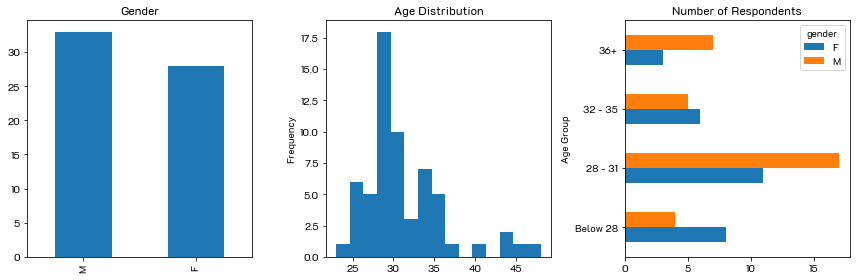

In [11]:
f, axes = plt.subplots(1,3, figsize=(12,4), tight_layout=True)

df['gender'].value_counts(dropna=False).plot(kind='bar', title='Gender', ax=axes[0])
df['age'].plot.hist(bins=15, title='Age Distribution', ax=axes[1])
df.groupby(['age_group','gender']).size().unstack().fillna(0).plot(kind='barh', xlabel='Age Group', ylabel='Number of Respondents', 
                                                                   title='Number of Respondents', ax=axes[2]);
plt.savefig('demographic.png',dpi=100)
plt.show()

In [12]:
def process_interest(df):
    result = df.iloc[:,:30].melt(var_name='question', value_name='answer').groupby(['question','answer'], as_index=False).size().pivot('question','answer','size').fillna(0)
    result = result[intr_scale].reindex(df.columns[:30])
    result = result.apply(lambda x: x/x.sum(), axis=1)
    return result

int_overall_df = process_interest(df)
int_male_df = process_interest(df[df['gender']=='M'])
int_female_df = process_interest(df[df['gender']=='F'])

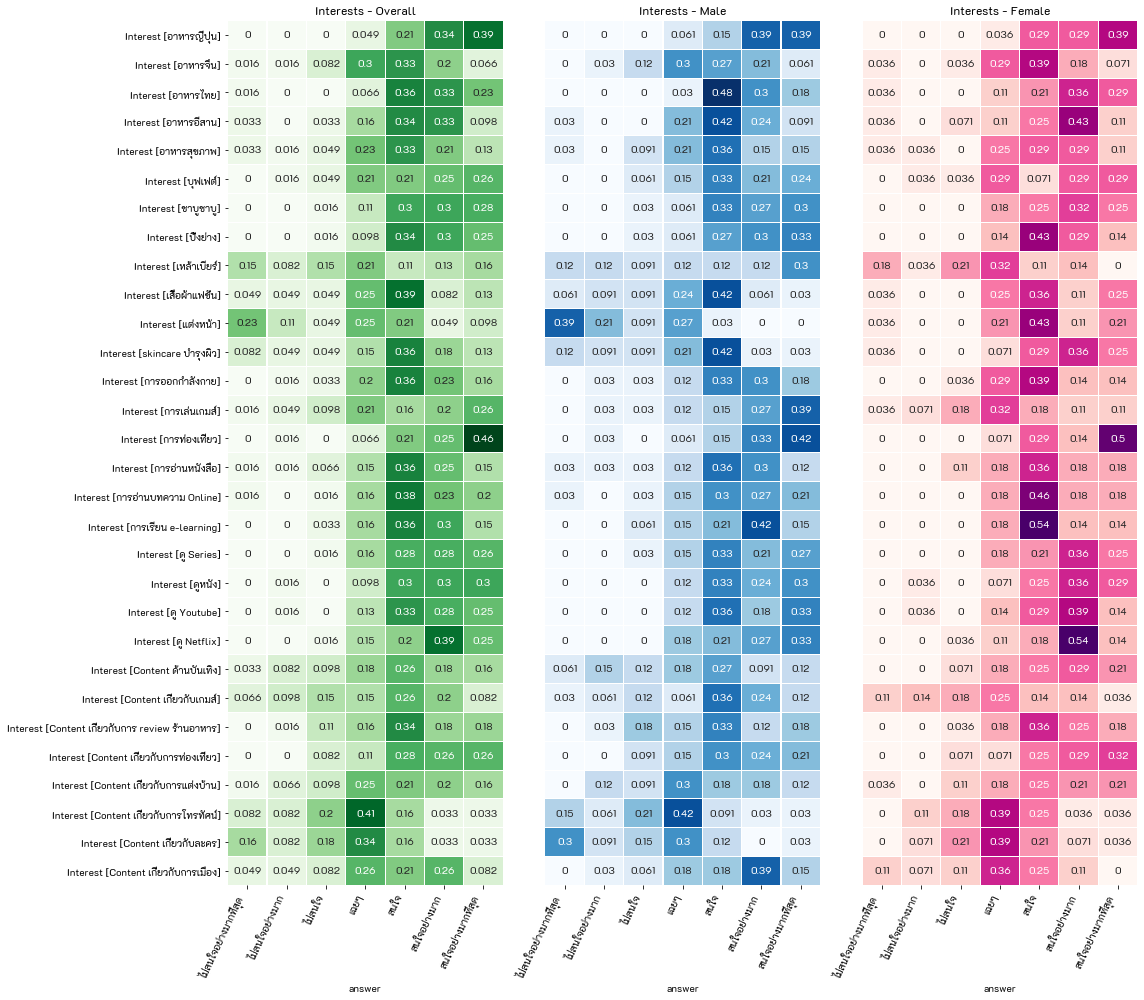

In [13]:
def plot_freq_heatmap(df, cmap, title):
    ax = sns.heatmap(df, cmap=cmap, annot=True, linewidth=.1, vmin=0, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=65, ha='right')
    ax.set_title(title)
    return ax

plt.subplots(1,3, figsize=(16,14), tight_layout=True)

plt.subplot(1,3,1)
plot_freq_heatmap(int_overall_df, 'Greens', 'Interests - Overall')

plt.subplot(1,3,2)
ax = plot_freq_heatmap(int_male_df, 'Blues', 'Interests - Male')
ax.set_yticks([])

plt.subplot(1,3,3)
ax = plot_freq_heatmap(int_female_df, 'RdPu', 'Interests - Female')
ax.set_yticks([])

plt.savefig('interest_freq.png', dpi=100)
plt.show()

In [14]:

def process_consumption(df):
    result = df.iloc[:,30:60].melt(var_name='question', value_name='answer').groupby(['question','answer'], as_index=False).size().pivot('question','answer','size').fillna(0)
    result = result[cons_scale].reindex(df.columns[30:60])
    result = result.apply(lambda x: x/x.sum(), axis=1)
    return result

con_overall_df = process_consumption(df)
con_male_df = process_consumption(df[df['gender']=='M'])
con_female_df = process_consumption(df[df['gender']=='F'])

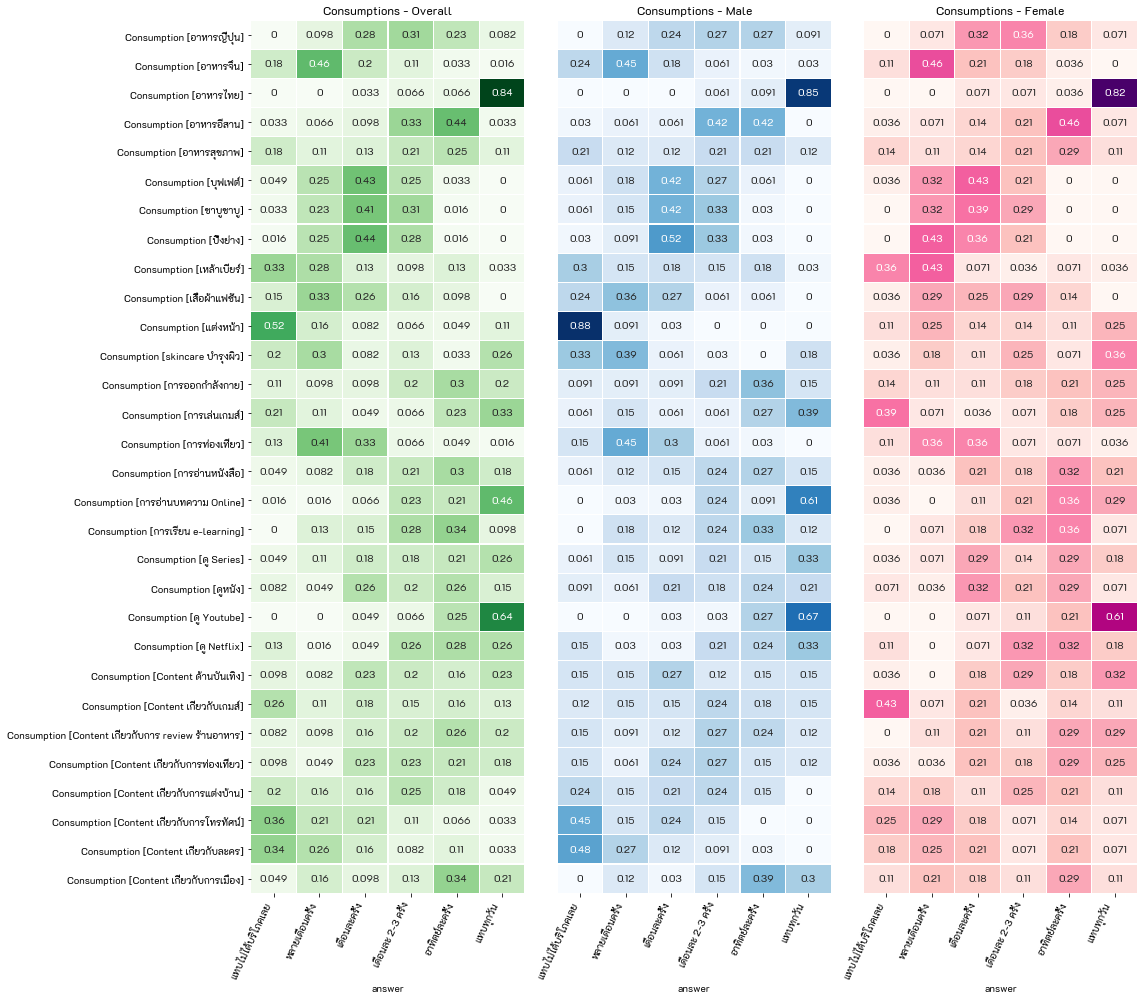

In [15]:
plt.subplots(1,3, figsize=(16,14), tight_layout=True)

plt.subplot(1,3,1)
plot_freq_heatmap(con_overall_df, 'Greens', 'Consumptions - Overall')

plt.subplot(1,3,2)
ax = plot_freq_heatmap(con_male_df, 'Blues', 'Consumptions - Male')
ax.set_yticks([])

plt.subplot(1,3,3)
ax = plot_freq_heatmap(con_female_df, 'RdPu', 'Consumptions - Female')
ax.set_yticks([])

plt.savefig('consumption_freq.png',dpi=100)
plt.show()

In [16]:
intr_questions = list(df.columns[:30])
cons_questions = list(df.columns[30:60])

intr_mapper = { v:i for i,v in enumerate(intr_scale,1) }
cons_mapper = { v:i for i,v in enumerate(cons_scale,1) }
print(intr_mapper, cons_mapper, sep='\n')

{'ไม่สนใจอย่างมากที่สุด': 1, 'ไม่สนใจอย่างมาก': 2, 'ไม่สนใจ': 3, 'เฉยๆ': 4, 'สนใจ': 5, 'สนใจอย่างมาก': 6, 'สนใจอย่างมากที่สุด': 7}
{'แทบไม่ได้บริโภคเลย': 1, 'หลายเดือนครั้ง': 2, 'เดือนละครั้ง': 3, 'เดือนละ 2-3 ครั้ง': 4, 'อาทิตย์ละครั้ง': 5, 'แทบทุกวัน': 6}


In [17]:
score_df = df[list(df.columns[:60]) + ['gender','age_group']].copy()

for col in score_df.columns[:30]:
    score_df[col] = score_df[col].map(intr_mapper).astype(int)

for col in score_df.columns[30:60]:
    score_df[col] = score_df[col].map(cons_mapper).astype(int)

score_df = score_df.melt(id_vars=['gender','age_group'], var_name='question', value_name='score')

In [18]:
intr_score_df = score_df[score_df['question'].isin(intr_questions)]
cons_score_df = score_df[score_df['question'].isin(cons_questions)]

In [19]:
score_df = df[list(df.columns[:60]) + ['gender','age']].copy()

for col in score_df.columns[:30]:
    score_df[col] = score_df[col].map(intr_mapper).astype(int)

for col in score_df.columns[30:60]:
    score_df[col] = score_df[col].map(cons_mapper).astype(int)

In [20]:
intr_df = score_df[list(score_df.columns[:30]) + ['gender','age']]
cons_df = score_df[list(score_df.columns[30:60]) + ['gender','age']]

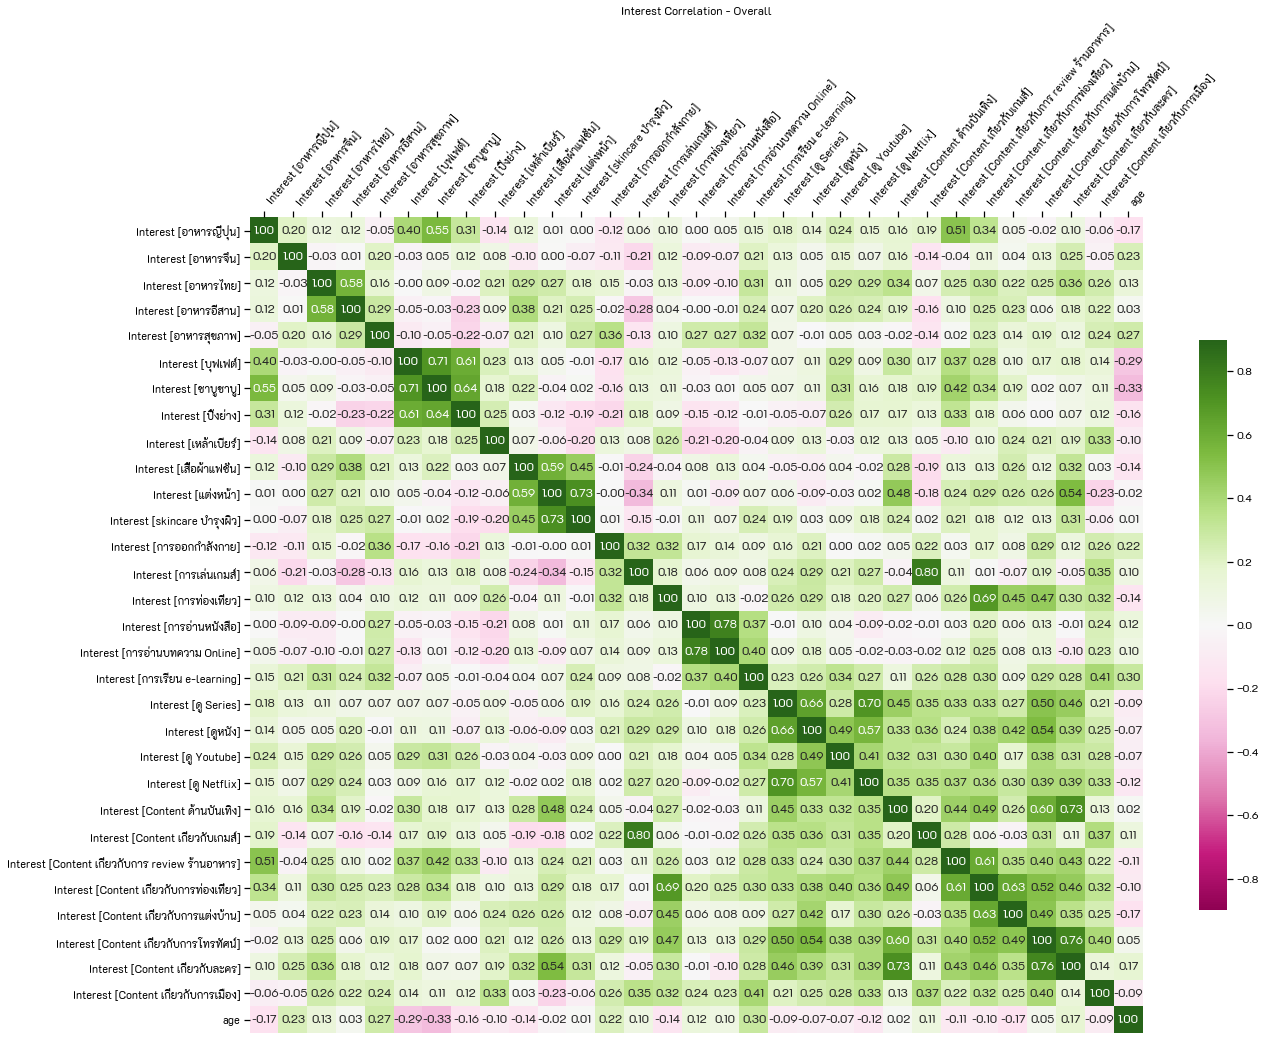

In [21]:
with sns.plotting_context("notebook", font_scale=.95):
    plt.figure(figsize=(20,15))
    ax = sns.heatmap(intr_df.corr(), cmap='PiYG', vmin=-.9, vmax=.9, annot=True, fmt='.2f', cbar_kws={"shrink":.70})
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, fontsize=11, ha='left')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)
    plt.title('Interest Correlation - Overall')
    plt.savefig('interest_corr_overall.png', dpi=100)
    plt.show()

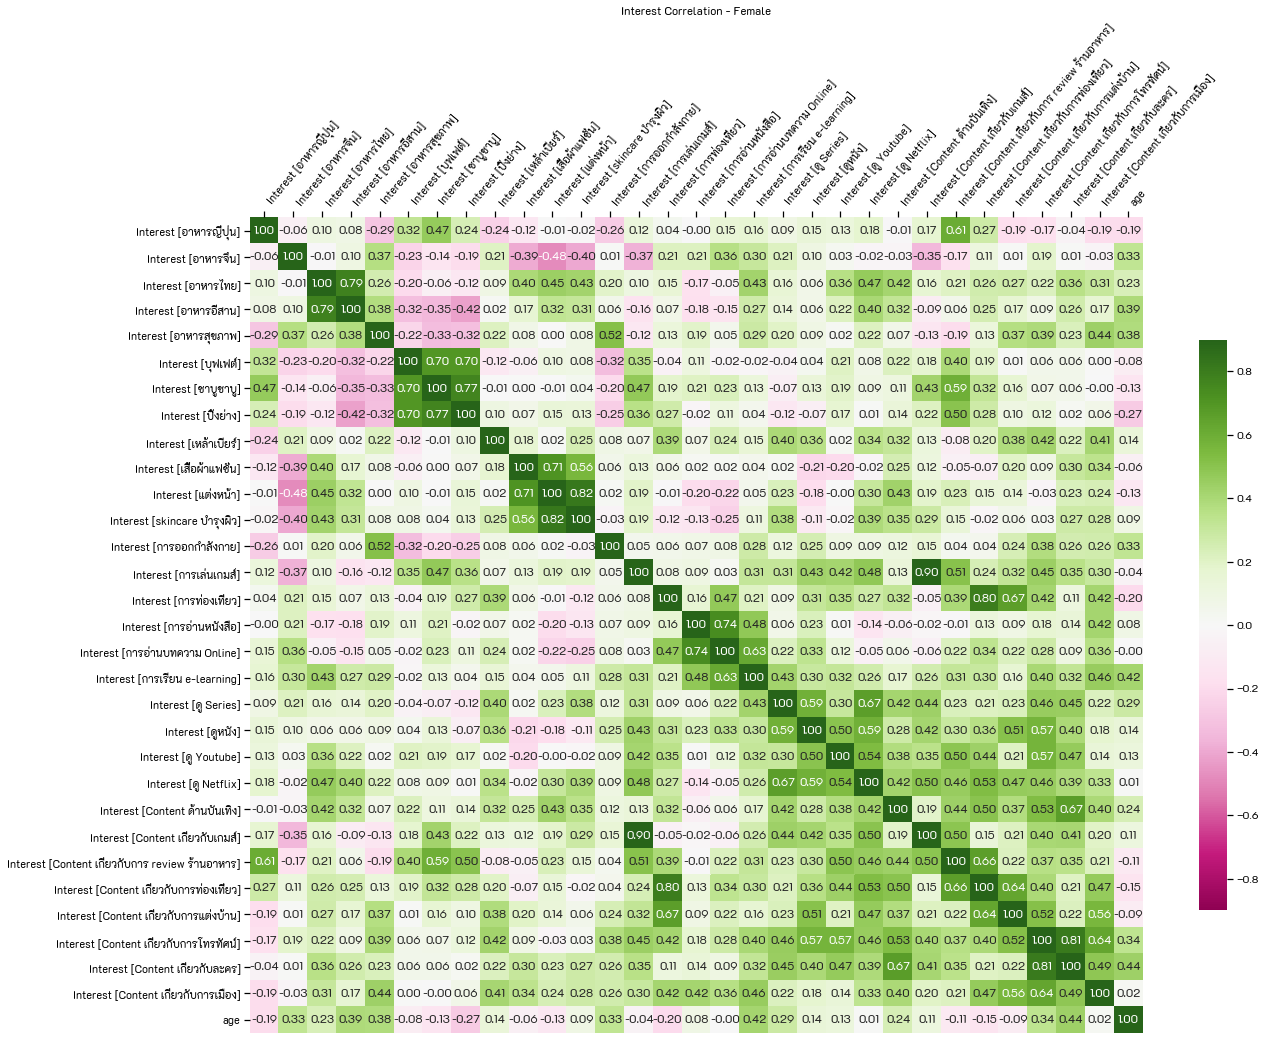

In [22]:

with sns.plotting_context("notebook", font_scale=.95):
    plt.figure(figsize=(20,15))
    ax = sns.heatmap(intr_df[intr_df['gender']=='F'].corr(), cmap='PiYG', vmin=-.9, vmax=.9, annot=True, fmt='.2f', cbar_kws={"shrink":.70})
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, fontsize=11, ha='left')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)
    plt.title('Interest Correlation - Female')
    plt.savefig('interest_corr_female.png', dpi=100)
    plt.show()